<a href="https://colab.research.google.com/github/ValeriaCastilloc/mydataproyects/blob/main/capgemini.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

hrdata_orig = pd.read_csv("employee.csv",delimiter=',')


##1. Descriptive analysis



In [ ]:
print(hrdata_orig.head())

   Age Attrition     BusinessTravel  DailyRate              Department  \
0   41       Yes      Travel_Rarely       1102                   Sales   
1   49        No  Travel_Frequently        279  Research & Development   
2   37       Yes      Travel_Rarely       1373  Research & Development   
3   33        No  Travel_Frequently       1392  Research & Development   
4   27        No      Travel_Rarely        591  Research & Development   

   DistanceFromHome  Education EducationField  EmployeeCount  EmployeeNumber  \
0                 1          2  Life Sciences              1               1   
1                 8          1  Life Sciences              1               2   
2                 2          2          Other              1               4   
3                 3          4  Life Sciences              1               5   
4                 2          1        Medical              1               7   

   ...  RelationshipSatisfaction StandardHours  StockOptionLevel  \
0  ...

In [ ]:
print("Shape of the dataset:", hrdata_orig.shape)

Shape of the dataset: (1470, 35)


In [ ]:
# Checking if missing values
print("Missing values:\n", hrdata_orig.isnull().sum())

# Summary statistics
print("Summary statistics:\n", hrdata_orig.describe())

# Checking the column names
print("Columns in the dataset:\n", hrdata_orig.columns)

Missing values:
 Age                         0
Attrition                   0
BusinessTravel              0
DailyRate                   0
Department                  0
DistanceFromHome            0
Education                   0
EducationField              0
EmployeeCount               0
EmployeeNumber              0
EnvironmentSatisfaction     0
Gender                      0
HourlyRate                  0
JobInvolvement              0
JobLevel                    0
JobRole                     0
JobSatisfaction             0
MaritalStatus               0
MonthlyIncome               0
MonthlyRate                 0
NumCompaniesWorked          0
Over18                      0
OverTime                    0
PercentSalaryHike           0
PerformanceRating           0
RelationshipSatisfaction    0
StandardHours               0
StockOptionLevel            0
TotalWorkingYears           0
TrainingTimesLastYear       0
WorkLifeBalance             0
YearsAtCompany              0
YearsInCurrentRole     

In [ ]:
hrdata_orig.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 35 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Age                       1470 non-null   int64 
 1   Attrition                 1470 non-null   object
 2   BusinessTravel            1470 non-null   object
 3   DailyRate                 1470 non-null   int64 
 4   Department                1470 non-null   object
 5   DistanceFromHome          1470 non-null   int64 
 6   Education                 1470 non-null   int64 
 7   EducationField            1470 non-null   object
 8   EmployeeCount             1470 non-null   int64 
 9   EmployeeNumber            1470 non-null   int64 
 10  EnvironmentSatisfaction   1470 non-null   int64 
 11  Gender                    1470 non-null   object
 12  HourlyRate                1470 non-null   int64 
 13  JobInvolvement            1470 non-null   int64 
 14  JobLevel                

In [ ]:
hrdata_orig=hrdata_orig.drop(["EmployeeCount", "StandardHours", "Over18", "EmployeeNumber"],axis=1) # dropping irrelevant
hrdata=pd.get_dummies(hrdata_orig, prefix=None, drop_first=True)
hrdata = hrdata.replace({True: 1, False: 0})


<ipython-input-6-d6fb711bfb30>:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  hrdata = hrdata.replace({True: 1, False: 0})


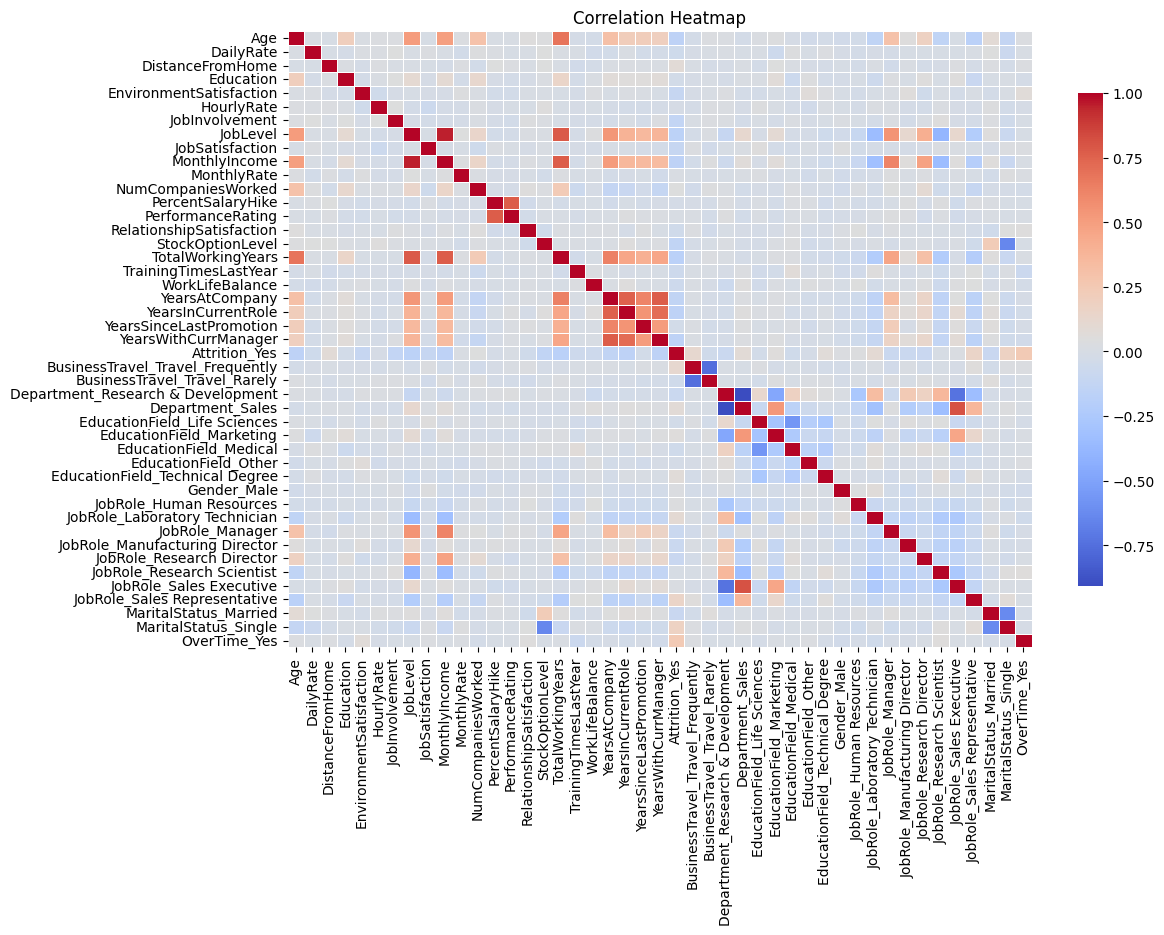

In [ ]:
# correlation to check before doing PCA
correlation_matrix = hrdata.corr()

# Visualization- Correlation Heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=False, fmt='.2f', cmap='coolwarm', linewidths=0.5,
            cbar_kws={'shrink': 0.8}, xticklabels=True, yticklabels=True)

plt.title("Correlation Heatmap")
plt.show()

In [ ]:
#Checking correlation within variables and dropping highly correlated ones keeping the important ones with the

corr_matrix = hrdata.corr().abs()

upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)) # avoiding duplicates through the upper triangle

# Finding features with correlation > X
corr_threshold = 0.6
high_corr_features = [column for column in upper.columns if any(upper[column] > corr_threshold)]

In [ ]:
target = 'Attrition_Yes'
target_corr = hrdata.corr()[target].abs()
features_to_drop = set()

for feature in high_corr_features:
    correlated_vars = upper.index[upper[feature] > corr_threshold].tolist()

    correlated_vars.append(feature)
    correlations = target_corr[correlated_vars].dropna()
    best_feature = correlations.idxmax()

    features_to_drop.update(set(correlated_vars) - {best_feature})

hrdata_final = hrdata.drop(columns=features_to_drop) # dropping highly correlated features
hrdata = hrdata_final
print(f"Features to drop: {features_to_drop}")
print(f"Shape of hrdata_final: {hrdata.shape}")

Features to drop: {'JobRole_Sales Executive', 'YearsAtCompany', 'StockOptionLevel', 'PerformanceRating', 'JobLevel', 'JobRole_Manager', 'MonthlyIncome', 'Department_Sales', 'Age', 'MaritalStatus_Married', 'BusinessTravel_Travel_Rarely', 'YearsWithCurrManager', 'YearsSinceLastPromotion'}
Shape of hrdata_final: (1470, 32)


## 2. Implementation and analysis of Principal Component Analysis (PCA) and K-means clustering on this PCA

In [ ]:
# Ensuring 'Attrition' column exists
if 'Attrition' in hrdata_orig.columns:
    hrdata_orig['Attrition_Yes'] = hrdata_orig['Attrition'].map({'Yes': 1, 'No': 0})
else:
    raise ValueError("The column 'Attrition' is missing from the dataset.")

# veryfing mapping
print("Unique values in Attrition_Yes before encoding:", hrdata_orig['Attrition_Yes'].unique())

Unique values in Attrition_Yes before encoding: [1 0]


In [ ]:
attrition_yes = hrdata_orig['Attrition_Yes'].copy()
hrdata = pd.get_dummies(hrdata_orig, drop_first=True)

# checking if duplicate columns
hrdata = hrdata.loc[:, ~hrdata.columns.duplicated()]

# Restoreing 'Attrition_Yes' after encoding
hrdata['Attrition_Yes'] = attrition_yes

# Separating 'Attrition_Yes' before scaling
attrition_yes = hrdata['Attrition_Yes']

# Standardizing numerical features (excluding target variable)
hrdata.drop(columns=['Attrition_Yes'], inplace=True)
scaler = StandardScaler()
hrdata_scaled = pd.DataFrame(scaler.fit_transform(hrdata), columns=hrdata.columns)

# Re-adding target variable after scaling
hrdata_scaled['Attrition_Yes'] = attrition_yes


Unique values in Attrition_Yes after fixing scaling issue: [1 0]


In [ ]:
target_variable = 'Attrition_Yes'

# Extracting X and y
y = hrdata_scaled[target_variable].astype(int)
X = hrdata_scaled.drop(columns=[target_variable])

# dividning training and testing splits
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training Size: {X_train.shape}, Testing Size: {X_test.shape}")
print("Unique values in target variable AFTER:", y.unique())

Training Size: (1176, 44), Testing Size: (294, 44)
Unique values in target variable AFTER: [1 0]


Number of PCA components retaining at least 80% variance: 23


Text(0.5, 1.0, 'PCA ')

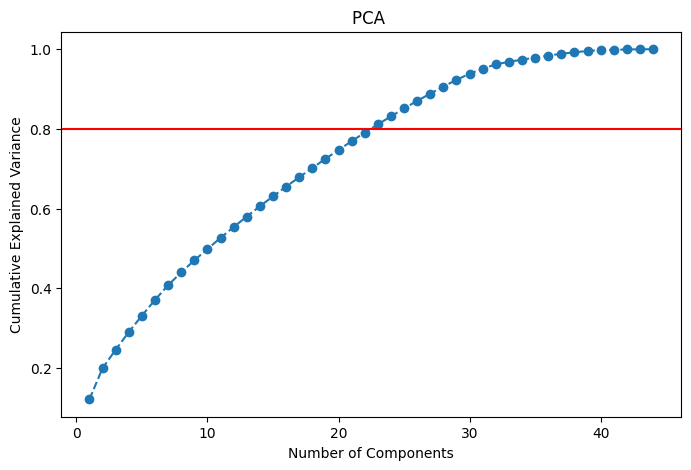

In [ ]:
from sklearn.decomposition import PCA

pca = PCA()
pca.fit(X_train)

# cumulative explained variance
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

# Minimum number of components that retain at least 80% variance
components = np.argmax(cumulative_variance >= 0.80) + 1

print(f"Number of PCA components retaining at least 80% variance: {components}")

# Applying PCA with the optimal number of components
pca = PCA(n_components=components)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

# Visualizing variance
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='--')
plt.axhline(y=0.80, color='r', linestyle='-')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA ')

In [ ]:
# PCA for dimensionality reduction - Using Function
pca = PCA(n_components=0.8) # Explained variance ratio of 80%
hrdata_pca = pca.fit_transform(X)
print("Variance:", pca.explained_variance_ratio_)
print("Number of components:", pca.n_components_)

Variance: [0.12130945 0.07848152 0.04705972 0.04519088 0.04058483 0.03907264
 0.03652828 0.03056292 0.0295585  0.02817488 0.02752981 0.02672277
 0.02609425 0.02590854 0.02439591 0.02401066 0.02355073 0.02326705
 0.02273103 0.02216941 0.02192254 0.02168988 0.02122813]
Number of components: 23


In [ ]:
# PCA for dimensionality reduction - Manual Way
#X = hrdata.copy() #  creating a copy to avoid modifying the original hrdata.

#if 'Attrition_Yes' in X.columns:
    #X = X.drop(columns=['Attrition_Yes'])

# Standardize the data
#X_std = (X - np.mean(X, axis=0)) / np.std(X, axis=0, ddof=0) # using ddof=0 since we are dividing by the population std.


# Correlation matrix

#Corr_mat = np.corrcoef(X_std.transpose())

# Dimensions of X_std
#N = np.shape(X_std)[0]
#K = np.shape(X_std)[1]

# Eigenvalues and Eigenvectors
#Lamb, V = np.linalg.eig(Corr_mat)

# Ordering in descending order
#idx_sort = -1 * np.argsort(-1 * Lamb)
#Lamb_sort = Lamb[idx_sort]


#V_sort = V[:, idx_sort] # ordering eigenvectors


#pc_eigenvalues = -np.sort(-Lamb) # ordering eigenvalues

# Compute the aggregated variance explained by the principal componentes
#pc_eigenvalues = np.cumsum(pc_eigenvalues / np.sum(pc_eigenvalues))

#print('Eigenvalues:',pc_eigenvalues)

# #Components that explain at least the 80% of the variance
#number = np.argmax(pc_eigenvalues >= 0.8) + 1
#print("80% of the data is explained by " + str(number), 'components')

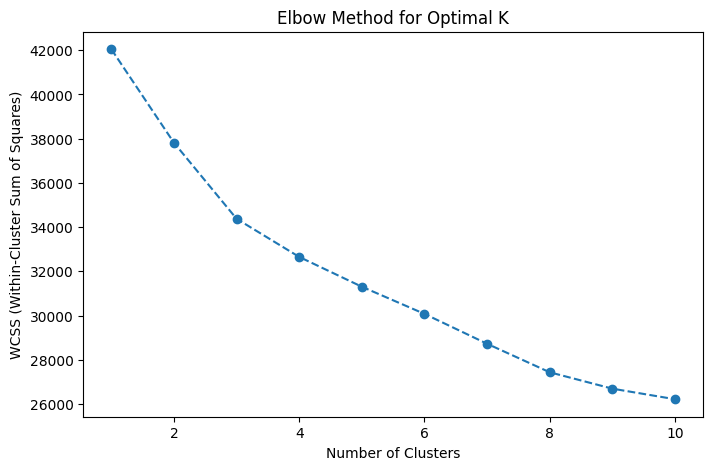

In [ ]:
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=42, n_init=10)
    kmeans.fit(X_train_pca)
    wcss.append(kmeans.inertia_)

# Plot the Elbow Method graph
plt.figure(figsize=(8, 5))
plt.plot(range(1, 11), wcss, marker='o', linestyle='--')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS (Within-Cluster Sum of Squares)')
plt.title('Elbow Method for Optimal K')
plt.show()

In [ ]:
from sklearn.metrics import silhouette_score

# comparing scores with different # of clusters
for n_clusters in [2,3,4, 5,6]:
  kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
  kmeans.fit(X_train_pca)
  cluster_labels = kmeans.labels_
  silhouette_avg = silhouette_score(X_train_pca, cluster_labels)
  print(f"For n_clusters = {n_clusters}, the average silhouette_score is : {silhouette_avg}")

For n_clusters = 2, the average silhouette_score is : 0.11117838770086662
For n_clusters = 3, the average silhouette_score is : 0.12068544799729768
For n_clusters = 4, the average silhouette_score is : 0.1285533992170999
For n_clusters = 5, the average silhouette_score is : 0.1076374073778013
For n_clusters = 6, the average silhouette_score is : 0.11832057927715456


4 clusters seems to be the most optimal choice based on both methods.

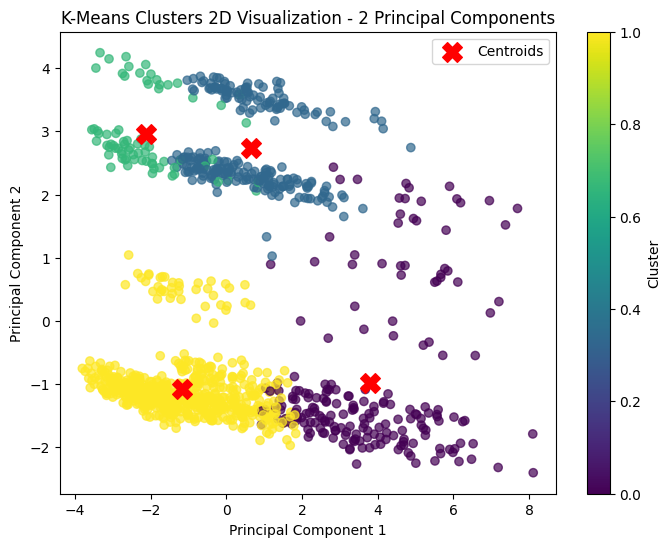

In [ ]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Applying KMeans with the optimal number of clusters (4 in this case)
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
clusters = kmeans.fit_predict(X_train_pca)

# Getting centroids
centroids = kmeans.cluster_centers_

# Plot clusters with centroids
plt.figure(figsize=(8, 6))
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=clusters, cmap='viridis', alpha=0.7)
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', marker='X', s=200, label="Centroids")  # Adding centroids
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('K-Means Clusters 2D Visualization - 2 Principal Components')
plt.colorbar(label='Cluster')
plt.legend()
plt.show()


In [ ]:
# Cluster size (data points)
cluster_labels = kmeans.labels_

# dictionary to store cluster sizes
cluster_sizes = {}

for cluster_id in range(kmeans.n_clusters):
    # Counting data points in each cluster
    cluster_sizes[cluster_id] = np.sum(cluster_labels == cluster_id)

for cluster_id, size in cluster_sizes.items():
    print(f"Cluster {cluster_id}: {size} data points")

Cluster 0: 203 data points
Cluster 1: 249 data points
Cluster 2: 75 data points
Cluster 3: 649 data points


## 3. Training and analysis of a prediction model based on decision trees

In [ ]:
#Adding  cluster labels as features
X_train_with_clusters = np.column_stack((X_train_pca, cluster_labels))
X_test_with_clusters = np.column_stack((X_test_pca, kmeans.predict(X_test_pca)))

# --- Logistic Regression---
from sklearn.linear_model import LogisticRegression

logreg_model = LogisticRegression(random_state=42)
logreg_model.fit(X_train_with_clusters, y_train)

y_pred = logreg_model.predict(X_test_with_clusters)

accuracy = accuracy_score(y_test, y_pred)
print(f"Logistic regression Accuracy: {accuracy}")
report = classification_report(y_test, y_pred, output_dict=True) # Getting report as a dictionary
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))


# --- Decision Tree---
dt_classifier = DecisionTreeClassifier(random_state=42)
dt_classifier.fit(X_train_with_clusters, y_train)

y_pred_dt = dt_classifier.predict(X_test_with_clusters)

accuracy_dt = accuracy_score(y_test, y_pred_dt)
print(f"Decision Tree Accuracy: {accuracy_dt}")
report_dt = classification_report(y_test, y_pred_dt, output_dict=True)
print(classification_report(y_test, y_pred_dt))

# --- Random Forest---
rf_classifier = RandomForestClassifier(random_state=42)
rf_classifier.fit(X_train_with_clusters, y_train)

y_pred_rf = rf_classifier.predict(X_test_with_clusters)

accuracy_rf = accuracy_score(y_test, y_pred_rf)
print(f"Random Forest Accuracy: {accuracy_rf}")
report_rf = classification_report(y_test, y_pred_rf, output_dict=True)
print(classification_report(y_test, y_pred_rf))

# ---XGBoost---
xgb_model = xgb.XGBClassifier(random_state=42)
xgb_model.fit(X_train_with_clusters, y_train)

y_pred_xgb = xgb_model.predict(X_test_with_clusters)

accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
print(f"XGBoost Accuracy: {accuracy_xgb}")
report_xgb = classification_report(y_test, y_pred_xgb, output_dict=True)
print(classification_report(y_test, y_pred_xgb))


Logistic regression Accuracy: 0.8809523809523809
              precision    recall  f1-score   support

           0       0.90      0.96      0.93       255
           1       0.59      0.33      0.43        39

    accuracy                           0.88       294
   macro avg       0.75      0.65      0.68       294
weighted avg       0.86      0.88      0.87       294

[[246   9]
 [ 26  13]]
Decision Tree Accuracy: 0.7925170068027211
              precision    recall  f1-score   support

           0       0.89      0.87      0.88       255
           1       0.25      0.28      0.27        39

    accuracy                           0.79       294
   macro avg       0.57      0.58      0.57       294
weighted avg       0.80      0.79      0.80       294

Random Forest Accuracy: 0.8843537414965986
              precision    recall  f1-score   support

           0       0.88      1.00      0.94       255
           1       1.00      0.13      0.23        39

    accuracy            

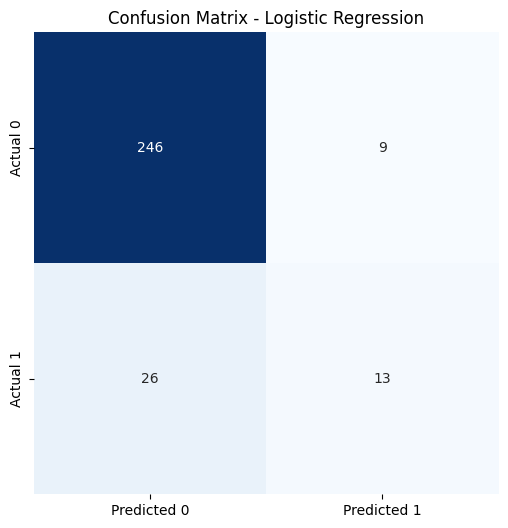

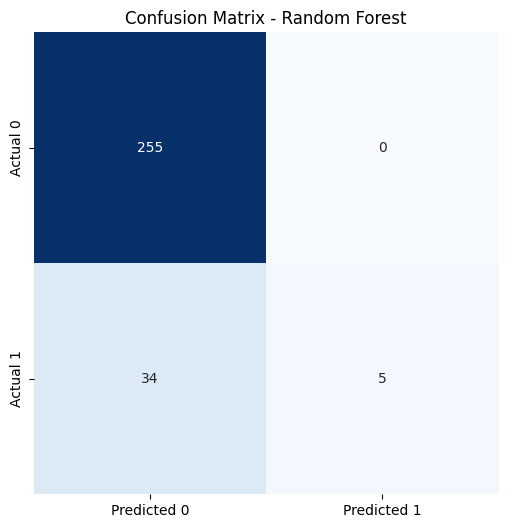

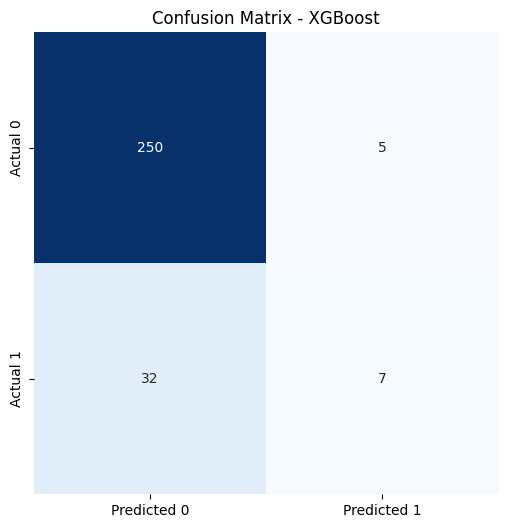

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Logistic Regression Confusion Matrix
cm_logreg = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 6))
sns.heatmap(cm_logreg, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.title('Confusion Matrix - Logistic Regression')
plt.show()

# Random Forest Confusion Matrix
cm_rf = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(6, 6))
sns.heatmap(cm_rf, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.title('Confusion Matrix - Random Forest')
plt.show()

# XGBoost Confusion Matrix
cm_xgb = confusion_matrix(y_test, y_pred_xgb)
plt.figure(figsize=(6, 6))
sns.heatmap(cm_xgb, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.title('Confusion Matrix - XGBoost')
plt.show()

 - XGBoost in this case will be selected as the best model since it slightly performs better as it identifies more attrition cases and has high accuracy (0.88) in comparison to Random Forest.

## 4. Analysis of a SHAP (SHapley Additive exPlanations) diagram

In [ ]:
import shap
explainer = shap.Explainer(xgb_model, X_train_with_clusters)
shap_values = explainer(X_test_with_clusters)

pca_feature_names = [f"PC{i+1}" for i in range(X_train_with_clusters.shape[1])]
shap_values_df = pd.DataFrame(shap_values.values, columns=pca_feature_names)

# Confirm shape
print("SHAP values dataframe shape:", shap_values_df.shape)
print("SHAP values dataframe preview:\n", shap_values_df.head())

SHAP values dataframe shape: (294, 24)
SHAP values dataframe preview:
         PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
0 -0.430013  0.532689  0.320878  0.901538  0.016724 -0.034460  0.057063   
1 -0.684883 -0.468176 -0.553031  0.456718 -0.135938 -0.485286  0.057423   
2  2.180293  0.694921 -1.053680  0.269667 -0.496033 -0.164296  0.225894   
3 -0.488533 -0.689617 -0.194303  0.833617 -0.050681 -0.391669 -0.169881   
4 -0.541171 -0.583988  0.335451  0.068942 -0.155644 -0.056717 -0.089604   

        PC8       PC9      PC10  ...      PC15      PC16      PC17      PC18  \
0 -0.464442  0.039946  0.010178  ...  0.202644  0.514037 -1.873043  0.163621   
1 -0.691057 -0.402674 -0.108349  ... -0.550813  0.129151 -1.020629 -0.071554   
2 -0.232210 -0.141559  0.020291  ... -0.574995  0.636003  1.069040  0.029728   
3 -0.216752 -0.085670  0.027927  ... -0.480666 -0.277484  0.197668 -0.098577   
4 -0.903237  0.447811 -0.061745  ...  0.152848 -0.194135 -1.149243  0.692268  

In [ ]:
# Fixing the mismatch by adjusting the number of PCA feature names
pca_feature_names = [f"PC{i+1}" for i in range(pca.components_.shape[0])]

# Creating a DataFrame for PCA loadings with the correct dimensions
pca_loadings = pd.DataFrame(pca.components_, columns=X.columns, index=pca_feature_names)

# Confirm shape matches
print("Updated PCA Components Shape:", pca.components_.shape)
print("Updated PCA Feature Names Length:", len(pca_feature_names))
print("PCA Loadings DataFrame Shape:", pca_loadings.shape)

Updated PCA Components Shape: (23, 44)
Updated PCA Feature Names Length: 23
PCA Loadings DataFrame Shape: (23, 44)


In [ ]:
# Creating a DataFrame for PCA loadings with the correct dimensions
pca_loadings = pd.DataFrame(pca.components_, columns=X.columns, index=pca_feature_names)

# Extracting SHAP values into a DataFrame with PCA feature names
pca_feature_names = [f"PC{i+1}" for i in range(X_train_with_clusters.shape[1])]
shap_values_df = pd.DataFrame(shap_values.values, columns=pca_feature_names)

# Identifying the 5 most influential PCA components
top_pca_components = shap_values_df.abs().mean().sort_values(ascending=False).head(5).index

# Getting explained variance for each PCA component
def get_explained_variance(components, variance_ratios):
    return {pc: variance_ratios[int(pc[2:]) - 1] for pc in components}

# Setting original features for each PCA component
def find_top_original_features(components, loadings, top_n=5):
    return {pc: loadings.loc[pc].abs().nlargest(top_n).index.tolist() for pc in components}

# Get explained variance ratios from the PCA object
explained_variance_ratios = pca.explained_variance_ratio_  # This line is added

explained_variance_dict = get_explained_variance(top_pca_components, explained_variance_ratios)
top_original_features = find_top_original_features(top_pca_components, pca_loadings)
#Printing results
for pc in top_pca_components:
    explained_variance = explained_variance_dict[pc]
    features = top_original_features[pc]
    print(f"{pc}: Explained Variance = {explained_variance:.4f}, {features}")

PC1: Explained Variance = 0.1213, ['JobLevel', 'MonthlyIncome', 'TotalWorkingYears', 'YearsAtCompany', 'YearsInCurrentRole']
PC17: Explained Variance = 0.0236, ['JobInvolvement', 'EducationField_Technical Degree', 'EducationField_Other', 'JobSatisfaction', 'WorkLifeBalance']
PC22: Explained Variance = 0.0217, ['JobRole_Sales Representative', 'HourlyRate', 'JobInvolvement', 'Education', 'TrainingTimesLastYear']
PC2: Explained Variance = 0.0785, ['Department_Sales', 'Department_Research & Development', 'JobRole_Sales Executive', 'EducationField_Marketing', 'JobRole_Sales Representative']
PC15: Explained Variance = 0.0244, ['DailyRate', 'JobSatisfaction', 'MonthlyRate', 'DistanceFromHome', 'JobInvolvement']


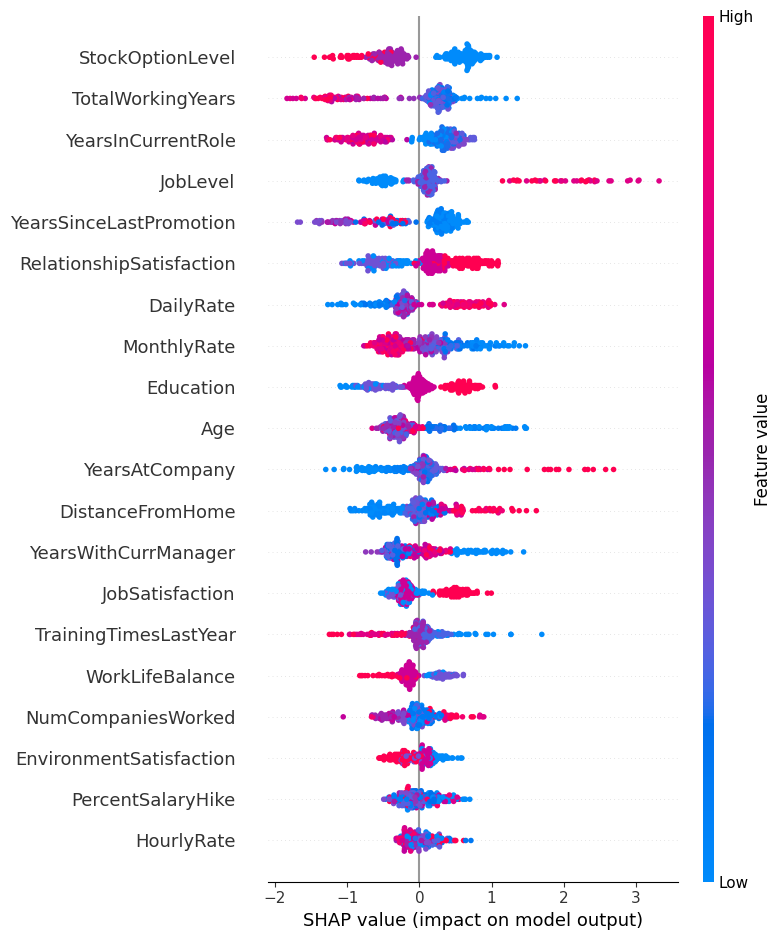

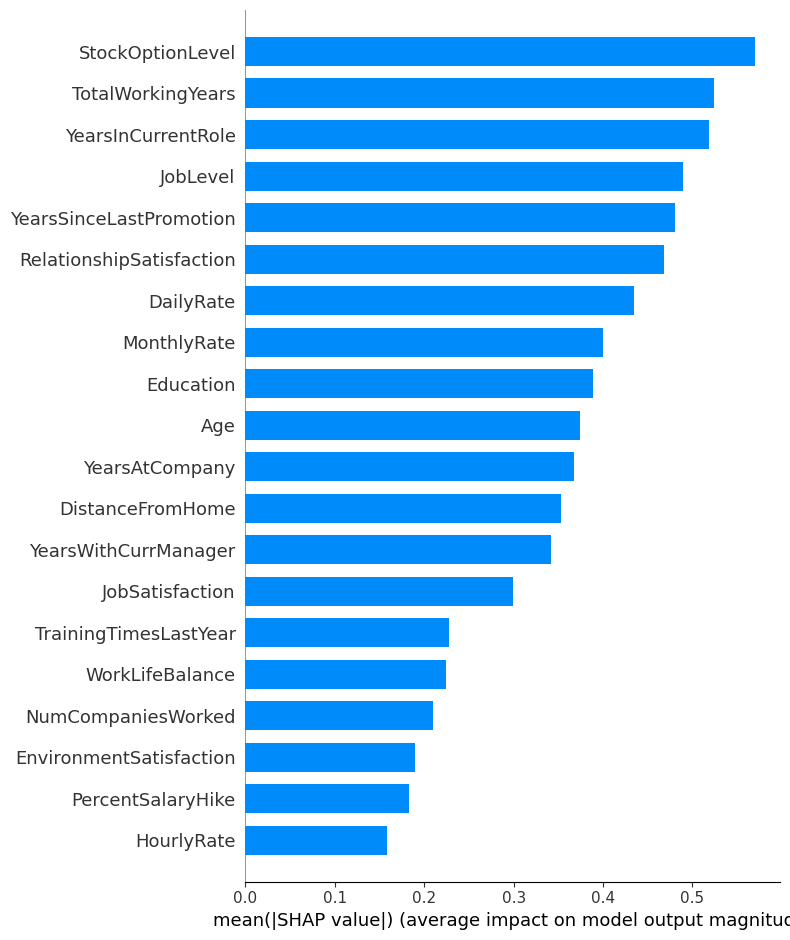

In [ ]:
import shap

# SHAP values using the original features:
explainer = shap.Explainer(xgb_model, X_train)
shap_values = explainer(X_test)

# summary plot (beeswarm and bar plot) with focus on Attrition_Yes:
shap.summary_plot(shap_values, X_test, plot_type="dot", class_names=["No Attrition", "Attrition"])
# bar plor
shap.summary_plot(shap_values, X_test, plot_type="bar", class_names=["No Attrition", "Attrition"])
plt.show()

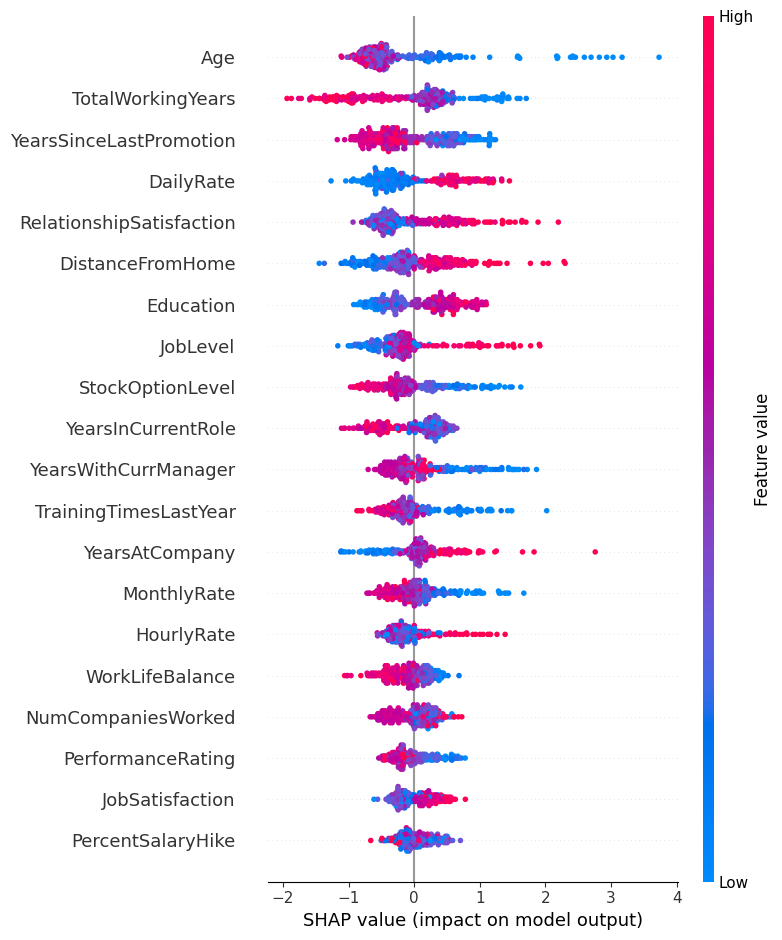

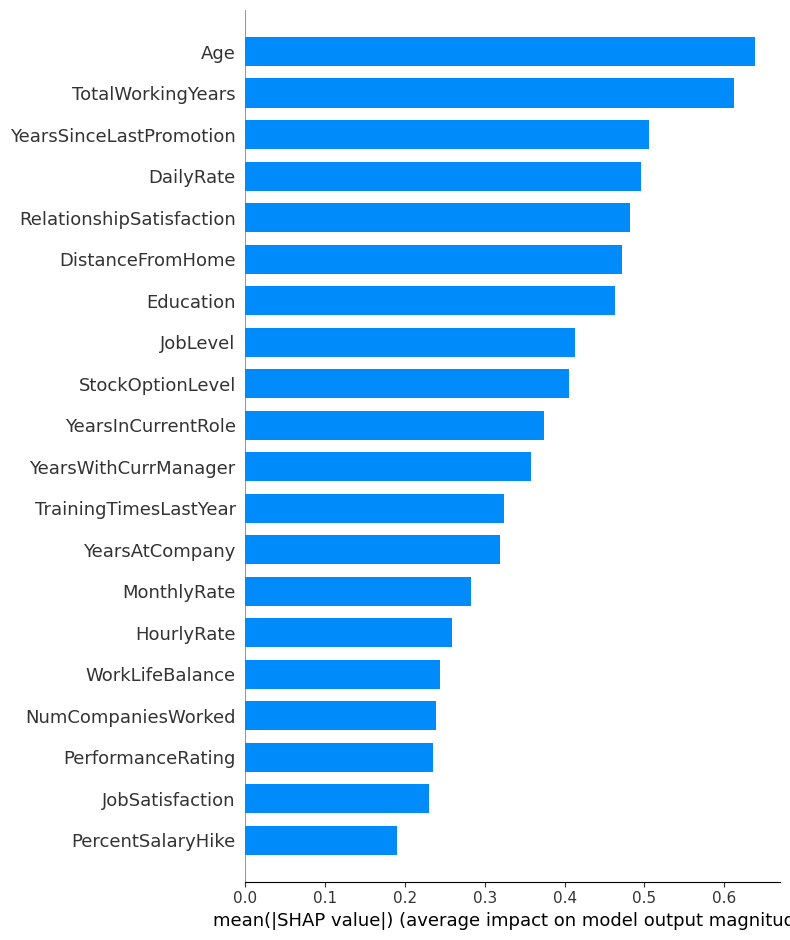

In [ ]:
# SHAP values using PCA-transformed data with Clusters
explainer = shap.Explainer(xgb_model, X_train_with_clusters)
shap_values = explainer(X_test_with_clusters)


# summary plot (beeswarm and bar plot) with focus on Attrition_Yes:
shap.summary_plot(shap_values, X_test_with_clusters, feature_names=X.columns.tolist()+["cluster"], plot_type="dot", class_names=["No Attrition", "Attrition"])
shap.summary_plot(shap_values, X_test_with_clusters, feature_names=X.columns.tolist()+["cluster"], plot_type="bar", class_names=["No Attrition", "Attrition"])
plt.show()